
# Filling Non-tidal Quantities Based on a Neighbor

**neighbor_fill.ipynb — user guide**  
*Generated 2025-11-02 05:52 UTC*

This notebook is a practical, self-contained guide for filling gaps in a target time series using a neighboring series
(e.g., **San Joaquin at Vernalis** (VNS) flow filled from **Mossdale Bridge** (MSD) subtidal flow), the example we use here.

---



## 1. Introduction

### Example Data and Typical Preprocessing
When a physically similar or proximate station is available, it can be advantageous to use that neighbor to impute missing
values in the target series. Our canonical example is **San Joaquin River flow at Vernalis (VNS)**, filled from the
subtidal component of **Mossdale Bridge (MSD)**:

- **MSD is tidal** → we prefilter with a subtidal filter (*e.g.*, `cosine_lanczos(..., '40h')`).  
- **MSD lags VNS** by ~4 hours → we estimate a fixed lag using the `calculate_lag` function and shift the neighbor before modeling.  
- **MSD sometimes has its own gaps** → we linearly interpolate *neighbor* briefly before filtering to avoid edge artifacts.
- **VNS − MSD** reflects seasonal channel depletions and episodic Paradise Cut/Weir overflow.

This notebook shows: (a) how to prepare data, (b) gap-filling methods, (c) how to compare methods on synthetic gaps,
and (d) how to store/reuse Dynamic-Factor (DFM) fits.

### Bottom Line on Methods (Quick Take)

- **Residual interpolation** (linear or PCHIP) is the most accurate *and* simple option **when the neighbor is present**. It is fairly easy to explain and it consistently reconstructs Vernalis from Mossdale well. However, it cannot fill when the neighbor is missing. Whether one can live with this limitation depends on the pair of data streams under consideration. In the Vernalis/Mossdale example this would leave about 10% of the data missing.
- **DFM (Trimbur)** is heavier-weight (requires fitting) but, with reasonable joint coverage, **produces complete, robust fills** (handles runs of missing values better than residual methods).
- **Substitution** and **global regression** are useful null baseline models but result in estimates that have high error and have no time connection to the main series. This will cause a lurching between the target series and the substitute at the edges of gaps. 

For VNS/MSD, residual-interp and DFM are the practical choices; pick **Residual-interp** for speed/simplicity or when you have complete data at the neighbor, **DFM** for completeness/robustness.



## 2. Setup

The code assumes your standard environment with `vtools`, `dms_datastore`, and `statsmodels`.  
If you're browsing the notebook without your environment, you can still read the narrative and formulas.

> **Modules**  
> - Data & utilities: `vtools`, `vtools.data.gap`  
> - Gap filling: `vtools.functions.neighbor_fill.fill_from_neighbor`  
> - Optional data provider: `dms_datastore.read_multi.read_ts_repo`


In [1]:

%load_ext autoreload
%autoreload 2

# Imports (plotting: matplotlib only; no seaborn)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from vtools.functions.neighbor_fill import fill_from_neighbor

from vtools import cosine_lanczos, calculate_lag, minutes
from vtools.data.gap import GapSpec, GapStrategy, apply_gaps

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams['axes.grid'] = True



## 3. Data: fetching & preprocessing

Below is a *template* `provide_example_data()` that illustrates a common setup for VNS/MSD:

1. Load both series on a common range.
2. Pre-filter **MSD** to subtidal (`cosine_lanczos`, e.g., 40h window).
3. Estimate the lag between the (filtered) neighbor and target (e.g., up to 14h), convert to steps, and shift the neighbor.
4. Return `(target, neighbor, regime)` where `regime` can be `None` or a categorical series (barrier in/out, season, etc.).


In [2]:

# You may replace this with a project-specific provider using dms_datastore.
# The function must return (target: Series, neighbor: Series|DataFrame, regime: Series|None),
# aligned (or alignable) by time.
def provide_example_data(start='2017-02-01', end='2022-12-01'):

    sjr = pd.read_csv("data/sjr_flow.csv", index_col=0, parse_dates=True).asfreq('15min')
    msd = pd.read_csv("data/msd_flow.csv", index_col=0, parse_dates=True).asfreq('15min')
    sjr  = sjr.squeeze().interpolate(limit=4)
    msd  = msd.squeeze().interpolate(limit=4)

    # Subtidal (non-tidal) component for MSD
    msd = cosine_lanczos(msd, '40h').squeeze()

    # Estimate and apply lag (non-calendar resolution recommended, e.g., '15min')
    lag_steps = int(calculate_lag(msd, sjr, max_lag='14h', res='15min')/minutes(15))
    msd = msd.shift(lag_steps)

    # Optional: regime (barrier, season, etc.) — using a placeholder here
    regime = None

    # Focus window
    return sjr.loc[pd.Timestamp(start):pd.Timestamp(end)], msd.loc[pd.Timestamp(start):pd.Timestamp(end)], regime

# Prepare example data
y, x, regime = provide_example_data()





# --- Stable, colorblind-safe colors and a label->color lookup ----------------
# Okabe–Ito palette (colorblind friendly)
OKABE_ITO = [
    "#E69F00",  # 0 orange           (reserved for neighbor)
    "#56B4E9",  # 1 sky blue
    "#009E73",  # 2 bluish green
    "#0072B2",  # 4 blue
    "#D55E00",  # 5 vermillion
    "#CC79A7",  # 6 reddish purple
    "#999999",  # 7 grey
    "#F0E442",  # 3 yellow    
]

# Fixed order for algorithms you commonly plot (extend as needed)
ALGO_ORDER = [
    "ols",
    "huber",
    "rolling",
    "lagged_reg",
    "loess",
    "dfm_trimbur_rw",
    "dfm_trimbur_ar",
    "resid_interp_linear",
    "resid_interp_pchip",
    "substitute",
]

# Build a stable color map for algorithms: skip palette[0] (reserved for neighbor)
_NEIGHBOR_COLOR = OKABE_ITO[0]
_ALGO_COLORS = {algo: OKABE_ITO[(i % (len(OKABE_ITO) - 1)) + 1]  # 1..end
                for i, algo in enumerate(ALGO_ORDER)}

def _normalize_label(s: str) -> str:
    # normalize method labels like "dfm trimbur rw" / "dfm_trimbur_rw"
    return s.strip().lower().replace(" ", "_")

def color_for(label: str) -> str:
    """
    Return a consistent color for a plotted series, based on its label.

    Rules:
      - "target (gapped)" -> black
      - "target (true)"   -> gray
      - "neighbor"        -> first palette color (reserved)
      - algorithms        -> stable color from palette by name
      - unknown labels    -> deterministic fallback into palette (excluding neighbor color)
    """
    lab = label.strip().lower()

    # fixed roles
    if lab == "target (gapped)":
        return "#000000"  # black
    if lab == "target (true)":
        return "#666666"  # thin gray recommended
    if lab == "neighbor":
        return _NEIGHBOR_COLOR

    # algorithms by name
    key = _normalize_label(label)
    if key in _ALGO_COLORS:
        return _ALGO_COLORS[key]

    # deterministic fallback for anything else (exclude index 0)
    idx = (abs(hash(key)) % (len(OKABE_ITO) - 1)) + 1
    return OKABE_ITO[idx]




## 4. Methods at a glance

We support a family of neighbor-based approaches (choose via `method=`):

- **`'substitute'`** — simple substitution: use neighbor only where target is missing.
- **`'ols'` / `'huber'`** — linear regression (ordinary / robust-Huber) on overlap.
- **`'loess2d'`** — nonparametric 2-D smoother in `(time, x)`; captures slow drift vs time.
- **`'resid_interp_linear'` / `'resid_interp_pchip'`** — difference the $\text{target}-\text{neighbor}$ series to form residuals. Interpolate the residuals with linear or higher order shape-preserving splines, then add the now-complete residuals back to the neighbor.
- **`'rolling_regression'`** — short-window OLS with time-varying coefficients [poor performer in speed and accuracy].
- **`'lagged_elasticnet'`** — regularized regression on lagged neighbor(s). [not recommended]
- **Dynamic Factor (DFM)** variants:
  - **`'dfm_trimbur_ar'` / `'dfm_trimbur_rw'`** — common-trend factor with Trimbur local linear trend; anomaly AR(1) or RW.

Residual-interp is the simplest and often the best choice (requires neighbor present); DFM is best for complete, robust fills (requires fitting).


> The methods are described in the subsections below. All methods are accessed via the single API `fill_from_neighbor(target, neighbor, method=...)`.



### 4.1 Linear and robust regression

We fit a global least squares fit where both `y` and `x` are observed. For Ordinary Least Squares (OLS):

$$
y_t = \alpha + \beta x_t + \varepsilon_t, \qquad \hat y_t = \hat\alpha + \hat\beta x_t.
$$

Robust (Huber) replaces least-squares with a Huber loss $\rho_\delta(\cdot)$ to reduce outlier influence.



### 4.2 Two-dimensional LOESS-like regression (time & neighbor)

Model the slow drift with time while retaining dependence on the neighbor:

$$
y_t \approx f(t, x_t).
$$

Implemented via distance-weighted KNN in standardized feature space $(t, x)$.



### 4.3 Residual-based filling (linear / PCHIP)

1. Fit the baseline on overlap: $y_t \approx a + b x_t$.  
2. Compute residuals: $r_t = y_t - (a + b x_t)$.  
3. **Interpolate $r_t$** inside *bounded* gaps only (no extrapolation) using **linear** or **PCHIP** in time.  
4. Recompose: $\hat y_t = (a + b x_t) + \tilde r_t$.

This preserves local curvature better than interpolating the original series directly.



### 4.4 Dynamic Factor (DFM) with Trimbur local-trend and anomalies

In this method, the **structural model** describes how both the target and the neighbor share a slowly evolving
**common trend** $\mu_t$ that captures basin-scale behavior such as overall inflow, channel depletion, or other broad
hydrologic controls. The companion term $\beta_t$ acts as a local slope or rate of change, so together $(\mu_t,\beta_t)$
form a *local linear trend* that can drift gradually over time. Excellent texts on structural time series modeling include 
Harvey’s *Forecasting, Structural Time Series Models and the Kalman Filter* (1990) and 
Koopman & Durbin’s *Time Series Analysis by State Space Methods* (2012). 

Dynamic common factor models tend to be hard to fit if you layer in a lot of additional anomalies or include too many factors 
without constraints, so the practical choice here is one common trend, which we apply verbatim (with observation noise) to 
the neighbor (MSD) since it is smoother. An **AR(1) or random walk anomaly** terms $a^y_t$ and $a^x_t$ represents 
short-term departures from that shared trend at Vernalis — mostly due to channel depletions but also encompassing 
time correlated measurement noise or operational perturbations.  For the AR(1) case the autoregressive parameter $\phi$ controls their persistence:
- if $|\phi|$ is small, deviations decay rapidly (almost white noise). Such a model is not sufficient to model the very persistent perturbations 
  caused by seasonal channel depletions.
- if $|\phi|$ is near 1, they behave like random walks, allowing slow reversion.
- the choice $\phi=1$ is the random walk model

This decomposition lets the Kalman smoother use the correlation structure between $y_t$ and $x_t$ to infer missing
values from the shared state rather than direct regression alone.  
The DFM effectively learns how much of the variance is **common** versus **local**, providing reconstructions that are
smooth, stable, and physically interpretable.  
For the Vernalis–Mossdale pair, the shared trend corresponds to large-scale San Joaquin flow variability, while the
anomaly terms capture residual tidal or measurement effects.


Let a common trend $\mu_t$ follow a **local linear trend** (Trimbur variant fixes level shock to zero):


$$
\begin{aligned}
\mu_t &= \mu_{t-1} + \beta_{t-1}, \\
\beta_t &= \beta_{t-1} + \eta_t, \qquad \eta_t \sim \mathcal{N}(0,q_\beta).
\end{aligned}
$$

Optional **anomaly** components $a^y_t, a^x_t$ capture idiosyncratic fluctuations in target/neighbor as AR(1) or RW:

$$
a_t = \phi a_{t-1} + \zeta_t \quad\text{(AR(1))} \qquad\text{or}\qquad a_t = a_{t-1} + \zeta_t \quad\text{(RW)}.
$$

**Observations:**

$$
\begin{aligned}
y_t &= \mu_t + \mathbf{1}_{\{a^y\}}\, a^y_t + \varepsilon^y_t,\qquad \varepsilon^y_t \sim \mathcal{N}(0,r_y), \\
x_t &= \lambda\,\mu_t + \mathbf{1}_{\{a^x\}}\, a^x_t + \varepsilon^x_t,\qquad \varepsilon^x_t \sim \mathcal{N}(0,r_x).
\end{aligned}
$$

where $\mathbf{1}_{\{a^y\}}$ and $\mathbf{1}_{\{a^x\}}$ are indicator variables (0 or 1) that specify whether the anomaly term is included for the target ($y$) or neighbor ($x$) series, respectively. 

Kalman smoothing provides $\hat y_t$ and an analytic PI via $\mathrm{Var}(y_t\mid\text{all}) = Z_t P_t Z_t' + H_t$. Note that while the "Kalman" name has a lot of name recognition, the Kalman smoother is just a statistical evaluation tool, not a complete description of the assumptions as above. Again Harvey (1990) is an excellent start and includes information on dynamic factor analysis which goes well beyond the simple one-component method described here. 



## 5. Simple substitution

This null model replaces **only the missing points** in `y` with the available `x`. It's cheap but not appreciably more
so than other methods. Below we highlight two issues with simple substitution that are shared by a great number of other 
models that do not consider time series properties.  
-  output tends to lurch over to the neighbor and back on entry and exit of the gap.  
-  there is no recourse when the neighbor is not available.


starting substitution
ending substitution


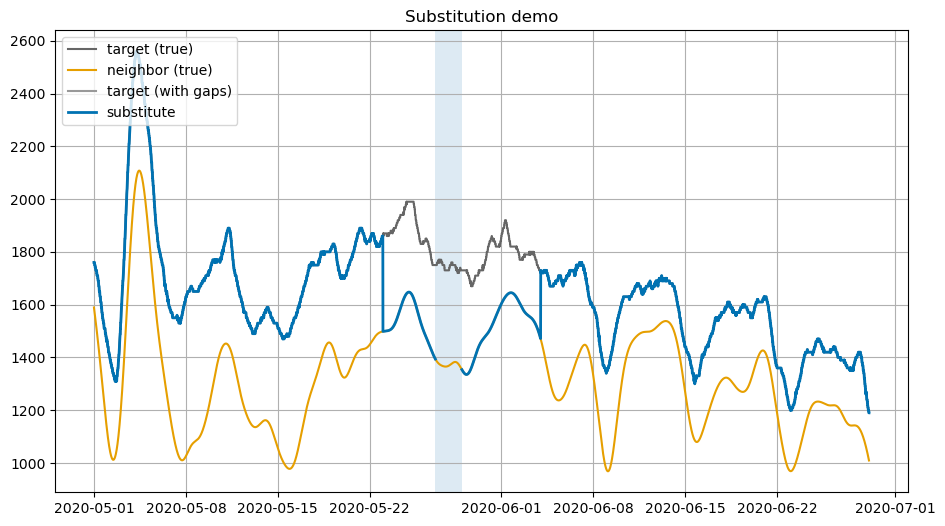

In [3]:
y_gap0 = y.copy()
x_gap0 = x.copy()
y_gap0.loc[pd.Timestamp('2020-05-23'):pd.Timestamp('2020-06-04')] = np.nan
x_gap0.loc[pd.Timestamp('2020-05-27'):pd.Timestamp('2020-05-29')] = np.nan


# Run the null 'substitute' method
print("starting substitution")
res_sub = fill_from_neighbor(y_gap0, x_gap0, method='substitute')
print("ending substitution")

# Plot two short windows to show transitions
def plot_window(t0, t1, title):
    fig, ax = plt.subplots()
    ax.plot(y.loc[t0:t1].index, y.loc[t0:t1].values, label='target (true)',
            color=color_for('target (true)'), linewidth=1.5)
    ax.plot(x.loc[t0:t1].index, x.loc[t0:t1].values, label='neighbor (true)',
            color=color_for('neighbor'), linewidth=1.5)
    ax.plot(y_gap0.loc[t0:t1].index, y_gap0.loc[t0:t1].values, label='target (with gaps)',
            color=color_for('target (with gaps)'), linewidth=1.5)
    ax.plot(res_sub['yhat'].loc[t0:t1].index, res_sub['filled'].loc[t0:t1].values,
            label='substitute', linewidth=2, color=color_for('substitute'))

    # Shade times where neighbor is missing
    nbr = x_gap0.loc[t0:t1]
    miss = nbr.isna()
    if miss.any():
        starts = np.where(np.diff(miss.astype(int), prepend=0, append=0)==1)[0]
        ends   = np.where(np.diff(miss.astype(int), prepend=0, append=0)==-1)[0] - 1
        for s, e in zip(starts, ends):
            ax.axvspan(nbr.index[s], nbr.index[e], alpha=0.15)

    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()

# Example windows (adjust as needed)

plot_window(pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-29'), 'Substitution demo')



## 6. Residual-based vs direct interpolation (visual)

In the picture below, we compare interpolating the original `y` versus interpolating **residuals** and then recombining. The direct interpolation doesn't have enough data to track curvature in the original series so it "cuts the corners". Residual-based methods
work on the smaller difference between the series, which though wiggly can still be linearly interpolated to much lower error. Note the much narrower y-axis range on the bottom plot below, which basically reduces the linear interpolation to the neighborhood of 100-200cfs instead of 1000s. As shown in the top plot the method of interpolating on residuals and adding back to the original "neighbor" to get back to original values works better in non-linear segments. One other thing you can see in the residual plots, because it is more of a close up, is the fuzzy measurement noise at the Vernalis sensor. The DFM methods naturally smooth this over.


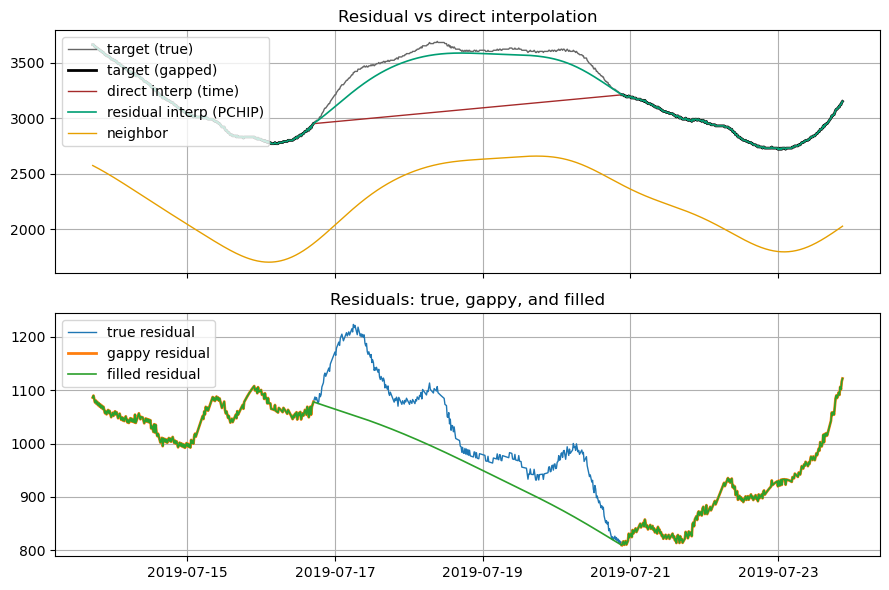

In [4]:

# Choose a curvy slice with a bounded gap
spec1 = GapSpec(n_gaps=1, min_len=400, max_len=400, seed=9, strategy=GapStrategy.TARGET_ONLY)
y1_gap, x1_gap, gaps2 = apply_gaps(y, x, spec1)

# (A) Direct time interpolation of y (inside-only)
y_direct = y1_gap.interpolate(method='time', limit_area='inside')

# (B) Residual-based interpolation via the API
res_resid = fill_from_neighbor(y1_gap, x1_gap, method='resid_interp_linear')

# Plot
t0 = list(gaps2['target'])[0][0] - pd.Timedelta('3D')
t1 = list(gaps2['target'])[0][1] + pd.Timedelta('3D')

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9, 6), sharex=True)

# Top: main series and fills
ax1.plot(y.loc[t0:t1], label='target (true)', color=color_for('target (true)'), linewidth=1.0)
ax1.plot(y1_gap.loc[t0:t1], label='target (gapped)', color=color_for('target (gapped)'), linewidth=2.0)
ax1.plot(y_direct.loc[t0:t1], label='direct interp (time)', color="brown", linewidth=1.0)
ax1.plot(res_resid['yhat'].loc[t0:t1], label='residual interp (PCHIP)', color=color_for('resid_interp_pchip'), linewidth=1.2)
ax1.plot(x1_gap.loc[t0:t1], label='neighbor', color=color_for('neighbor'), linewidth=1.0)
ax1.set_title('Residual vs direct interpolation')
ax1.legend(loc='upper left')

# Bottom: residuals
true_resid = y - x
gappy_resid = y1_gap - x1_gap
filled_resid = res_resid['yhat'] - x1_gap

ax2.plot(true_resid.loc[t0:t1], label='true residual', linewidth=1.0)
ax2.plot(gappy_resid.loc[t0:t1], label='gappy residual', linewidth=2.0)
ax2.plot(filled_resid.loc[t0:t1], label='filled residual', linewidth=1.2)
ax2.set_title('Residuals: true, gappy, and filled')
ax2.legend(loc='upper left')

plt.tight_layout()
plt.show()



## 7. Method catalog — sample calls

Below are concise examples for several methods. All return a dict with keys:
`filled`, `yhat`, optional `pi_lower`/`pi_upper`, `model_info`, and `metrics`. `filled` uses the original values where available, but imputes missing values as the algorithm is capable. `yhat` is estimates for the target time series which may include predictions at non-missing times. In the case of regression, the estimates may not be great and there may be a 'lurching' effect between original series and fill values. In the case of `dfm`, the `yhat` estimate may low-pass a lot of jitter in the instrument and conceivably is preferable to the origin data. PI stands for prediction interval, a measure of confidence in the estimate that is available with dfm and characterizes the growth of uncertainty with gap size. 


Z(y): [1. 0. 1.]  Z(x): [1.0403 0.     0.    ]
diag(T): [1. 1. 1.]
diag(Q): [0.00e+00 0.00e+00 1.09e-06]  diag(H): [1.e-05 1.e-05]
modes: factor=trimbur anom_mode=rw anom_var=target
active params: ['log_q_beta', 'log_q_ay', 'log_r_y', 'log_r_x', 'load']


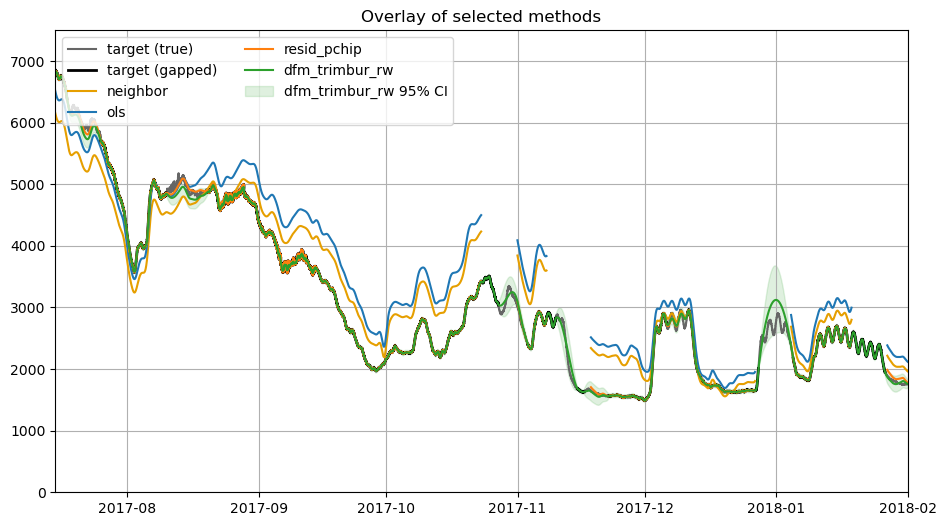

In [5]:
spec2 = GapSpec(n_gaps=100, min_len=400, max_len=1000, seed=9, strategy=GapStrategy.TARGET_ONLY)
y2_gap, x2_gap, gaps2 = apply_gaps(y, x, spec2)

# Common inputs
lags_0_4 = range(0, 5)

examples = {
    "substitute":       dict(method="substitute"),
    "ols":              dict(method="ols"),
    "huber":            dict(method="huber"),
    "loess2d":          dict(method="loess2d"),
    "resid_linear":     dict(method="resid_interp_linear"),
    "resid_pchip":      dict(method="resid_interp_pchip"),
    "rolling_reg":      dict(method="rolling_regression", window=72),
    "lagged_enet":      dict(method="lagged_elasticnet", lags=lags_0_4),
    "dfm_trimbur_ar":   dict(method="dfm_trimbur_ar"),
    "dfm_trimbur_rw":   dict(method="dfm_trimbur_rw"),
}

# Run a quick fit for selected methods
to_run = ["ols", "resid_pchip", "dfm_trimbur_rw"]
results = {name: fill_from_neighbor(y2_gap, x2_gap, **examples[name]) for name in to_run}

# Simple overlay plot
fig, ax = plt.subplots()
ax.plot(y, label='target (true)', color=color_for('target (true)'), linewidth=1.5)
ax.plot(y2_gap, label='target (gapped)', color=color_for('target (gapped)'), linewidth=2.0)
ax.plot(x2_gap, label='neighbor', color=color_for('neighbor'), linewidth=1.5)
#
for name, r in results.items():
    # draw the method line and keep the handle to fetch its color
    # draw the method line and keep the handle to fetch its color
    line, = ax.plot(r['yhat'].index,r['yhat'].values, label=name, linewidth=1.5)

    # add CI only for DFM-style methods, if available
    if name.startswith('dfm') and r.get('pi_lower') is not None and r.get('pi_upper') is not None:
        # ensure we have aligned Series for fill_between
        yhat = pd.Series(r['yhat'])
        pil  = pd.Series(r['pi_lower']).reindex(yhat.index)
        piu  = pd.Series(r['pi_upper']).reindex(yhat.index)
        color = line.get_color()
        ax.fill_between(pil.index, pil.values, piu.values,
                        alpha=0.15, color=color, label=f"{name} 95% CI")
ax.set_xlim(pd.Timestamp(2017, 7, 15), pd.Timestamp(2018, 2, 1))
ax.set_ylim(0,7500.0)
ax.set_title('Overlay of selected methods')
ax.legend(ncol=2, loc='upper left')
plt.show()



## 8. Comparisons on synthetic gaps

We evaluate each method on *known* artificial gaps. Following the analysis harness, we tabulate **coverage** and **RMSE**
segmented by neighbor availability:

- **RMSE_all** — over all overlapping timestamps.  
- **RMSE_all_with_neighbor** — where the neighbor is non-NaN.  
- **RMSE_in_gaps** — only where the target was synthetically gapped.  
- **RMSE_gaps_with_neighbor** — gap points *and* neighbor present.

These are often the most decision-relevant numbers when choosing a method. "All" in the RMSE table refers to all missing values in the target series. No RMSE is reported for "all" for methods such as OLS and residual interpolation which require the neighbor also be non-missing. A separate column for that case provides apples-to-apples comparison for times with supporting neighbor data. DFM is nearly as good as resdidual interpolation for cases where the neighbor is present and can survive periods when both sources of data are missing which is 10% of the data!! Timing data is output, which shows the main downside of DFM and that is the fitting time. Reapplication of DFM on a larger/later time set with pre-fit parameters on a few years is much faster and that workflow is the focus of the next section.  

In this particular comparison DFM comes out on top not only on coverage but on accuracy. This is NOT a  generalizable result -- as the period and length of gap are varied the RMSE estimates between methods will change by an amount that is greater than the difference between DFM and residual interpolation and. The latter are often a smidge more accurate. The main point is that they are about the same, so it is really about time versus coverage. 

In [6]:
import time

def _avail_mask(obj):
    return (obj.notna().any(axis=1) if isinstance(obj, pd.DataFrame) else obj.notna())

def rmse_by_mask(y_true, y_pred, mask):
    common = y_true.index.intersection(y_pred.index)
    if len(common) == 0:
        return np.nan
    m = mask.reindex(common).fillna(False)
    if not m.any():
        return np.nan
    resid = (y_true.reindex(common) - y_pred.reindex(common)).to_numpy()
    return float(np.sqrt(np.nanmean((resid[m.to_numpy()])**2)))

def _is_neighbor_required(method):
    # Add here any method that requires neighbor to be present for prediction
    return method in ['ols', 'huber', 'loess2d', 'resid_interp_linear', 'resid_interp_pchip', 'rolling_regression', 'lagged_elasticnet']

def _mask_exclude_leading_trailing(mask):
    # Only keep True inside the first and last True in the mask (i.e., exclude leading/trailing gaps)   
    idx = np.flatnonzero(mask)
    if len(idx) == 0:
        return mask
    mask2 = pd.Series(False, index=mask.index)
    mask2.iloc[idx[0]:idx[-1]+1] = mask.iloc[idx[0]:idx[-1]+1]
    return mask2

methods_for_table = ["substitute", "ols", "resid_interp_linear", "resid_interp_pchip", "dfm_trimbur_rw"]
fits = {}
for m in methods_for_table:
    print(f"Fitting method: {m} ...", end=" ", flush=True)
    t0 = time.time()
    fits[m] = fill_from_neighbor(y2_gap, x2_gap, method=m)
    t1 = time.time()
    print(f"done in {t1 - t0:.2f} s")

gap_mask = y2_gap.isna() 
nbr_mask = _avail_mask(x2_gap)

rows = []
for m, r in fits.items():
    yhat = r['yhat']
    # For methods that require neighbor, mask out where neighbor is missing (except leading/trailing)
    if _is_neighbor_required(m):
        valid_mask = nbr_mask
        gap_mask_valid = gap_mask & nbr_mask
        # Exclude leading/trailing gaps from this restriction
        gap_mask_valid = _mask_exclude_leading_trailing(gap_mask_valid)
        all_mask_valid = valid_mask
        all_mask_valid = _mask_exclude_leading_trailing(all_mask_valid)
        # If there are any False in all_mask_valid (i.e., neighbor missing inside), set RMSE to nan
        if not all_mask_valid.all():
            RMSE_all = np.nan
        else:
            RMSE_all = rmse_by_mask(y, yhat, mask=pd.Series(True, index=y.index))
        # For "in gaps", do not output for neighbor-required methods
        RMSE_in_gaps = np.nan
        RMSE_gaps_with_neighbor = rmse_by_mask(y, yhat, mask=(gap_mask & nbr_mask))
    else:
        RMSE_all = rmse_by_mask(y, yhat, mask=pd.Series(True, index=y.index))
        RMSE_in_gaps = rmse_by_mask(y, yhat, mask=gap_mask)
        RMSE_gaps_with_neighbor = rmse_by_mask(y, yhat, mask=(gap_mask & nbr_mask))
    rows.append({
        "method": m,
        "RMSE_all": RMSE_all,
        "RMSE_all_with_neighbor": rmse_by_mask(y, yhat, mask=nbr_mask),
        "RMSE_in_gaps": RMSE_in_gaps,
        "RMSE_gaps_with_neighbor": RMSE_gaps_with_neighbor,
    })

table = pd.DataFrame(rows).set_index("method").sort_index()
table


Fitting method: substitute ... done in 0.02 s
Fitting method: ols ... done in 0.08 s
Fitting method: resid_interp_linear ... done in 0.11 s
Fitting method: resid_interp_pchip ... done in 0.15 s
Fitting method: dfm_trimbur_rw ... Z(y): [1. 0. 1.]  Z(x): [1.0403 0.     0.    ]
diag(T): [1. 1. 1.]
diag(Q): [0.00e+00 0.00e+00 1.09e-06]  diag(H): [1.e-05 1.e-05]
modes: factor=trimbur anom_mode=rw anom_var=target
active params: ['log_q_beta', 'log_q_ay', 'log_r_y', 'log_r_x', 'load']
done in 74.68 s


,RMSE_all,RMSE_all_with_neighbor,RMSE_in_gaps,RMSE_gaps_with_neighbor
method,,,,
dfm_trimbur_rw,57.127105,55.100072,96.504941,93.092671
ols,NaN,549.685366,NaN,507.951475
resid_interp_linear,NaN,55.535812,NaN,94.703307
resid_interp_pchip,NaN,65.007505,NaN,110.855058
substitute,320.128587,325.340769,554.792402,554.792402



## 9. Storing & reusing DFM fits

You can save fitted DFM parameters and reload them to avoid re-estimation (useful for reproducible operations).
The exact helper names may vary by version; the example below shows a common pattern.


In [7]:

import time
from vtools.functions.neighbor_fill import (
    fill_from_neighbor,
    dfm_pack_params, save_dfm_params, load_dfm_params,
)

# --- 1. Fit once (expensive) -----------------------------------------------
t0 = time.perf_counter()

res_fit = fill_from_neighbor(
    y2_gap, x2_gap,
    method="dfm_trimbur_rw"
)


mi = res_fit["model_info"]
print("has fitted_params?", "fitted_params" in mi, type(mi.get("fitted_params")))

blob = mi.get("fitted_params")
assert isinstance(blob, dict) and "param_names" in blob and "transformed" in blob, "No fitted params!"

t1 = time.perf_counter()
fit_time = t1 - t0

print(f"DFM fit completed in {fit_time:.2f} seconds")
blob = dfm_pack_params(res_fit["model_info"])

# --- 2. Save parameters (YAML) --------------------------------------------
save_dfm_params(blob, "dfm_trimbur_rw_vns_msd.yaml")
print("Parameters saved to dfm_trimbur_rw_vns_msd.yaml")

# --- 3. Load and reuse (cheap) --------------------------------------------
t2 = time.perf_counter()

blob2 = load_dfm_params("dfm_trimbur_rw_vns_msd.yaml")
res_reuse = fill_from_neighbor(
    y2_gap, x2_gap,
    method="dfm_trimbur_rw",
    params=blob2      # skip fitting, just run the smoother
)

t3 = time.perf_counter()
reuse_time = t3 - t2

print(f"DFM reuse completed in {reuse_time:.3f} seconds")

# --- 4. Compare timings ----------------------------------------------------
print(f"\nSpeed-up from parameter reuse: {fit_time / reuse_time:,.1f}× faster")


Z(y): [1. 0. 1.]  Z(x): [1.0403 0.     0.    ]
diag(T): [1. 1. 1.]
diag(Q): [0.00e+00 0.00e+00 1.09e-06]  diag(H): [1.e-05 1.e-05]
modes: factor=trimbur anom_mode=rw anom_var=target
active params: ['log_q_beta', 'log_q_ay', 'log_r_y', 'log_r_x', 'load']
has fitted_params? True <class 'dict'>
DFM fit completed in 76.14 seconds
Parameters saved to dfm_trimbur_rw_vns_msd.yaml
Z(y): [1. 0. 1.]  Z(x): [1.0403 0.     0.    ]
diag(T): [1. 1. 1.]
diag(Q): [0.00e+00 0.00e+00 1.09e-06]  diag(H): [1.e-05 1.e-05]
modes: factor=trimbur anom_mode=rw anom_var=target
active params: ['log_q_beta', 'log_q_ay', 'log_r_y', 'log_r_x', 'load']
DFM reuse completed in 8.838 seconds

Speed-up from parameter reuse: 8.6× faster



## 10. Appendix — API summary

```python
fill_from_neighbor(
    target,                 # pd.Series
    neighbor,               # pd.Series | pd.DataFrame
    method: str,            # 'substitute' | 'ols' | 'huber' | 'loess2d' | 'resid_interp_linear' | 'resid_interp_pchip' |
                            # 'rolling_regression' | 'lagged_elasticnet' | 'state_space' | 'dfm_trimbur_ar' | 'dfm_trimbur_rw'
    lags=None,              # Iterable[int] for lagged methods (e.g., range(0,5))
    bounds=(None, None),    # optional min/max clipping after prediction
    window=None,            # for rolling regression
    **kwargs                # method-specific args (e.g., params=... for DFM reuse)
) -> dict  # with keys: filled, yhat, (pi_lower, pi_upper), model_info, metrics

API CONTRACT (neighbor_fill.fill_from_neighbor)

Signature
---------
fill_from_neighbor(
    target: pd.Series,
    neighbor: Union[pd.Series, pd.DataFrame],
    method: str = "substitute",
    regime: Optional[pd.Series] = None,
    bounds: Tuple[Optional[float], Optional[float]] = (None, None),
    *,
    params: Optional[dict] = None,
    **kwargs,
) -> Dict[str, Any]

Inputs
------
- target: Regular-grid pandas Series (DatetimeIndex), may contain NaNs (gaps).
- neighbor: Series or DataFrame on the *same* grid (same step & phase) as target.
- method: One of
    {'substitute','ols','huber','rolling','lagged_reg','loess',
     'dfm_trimbur_rw','dfm_trimbur_ar','resid_interp_linear','resid_interp_pchip'}
- regime (optional): Categorical Series aligned to target for per-regime fitting.
- bounds: (lo, hi) applied as a final clip to yhat.
- params: Packed fitted params for reuse (currently used by DFM backends).
- **kwargs: Method-specific options (see below).

Grid requirement
----------------
No internal resampling is performed. target and neighbor **must** be equally spaced
with identical step and phase. Regularize upstream as needed.

Method-specific **kwargs**
--------------------------
Common
  - lags: int | Sequence[int], optional
  - seed: int, optional

'ols'
  - lags: int | Sequence[int], optional
  - add_const / fit_intercept: bool (default True)

'huber'
  - lags: int | Sequence[int], optional
  - huber_t: float (default 1.35), maxiter: int (200), tol: float (1e-6)

'rolling'
  - window: int (REQUIRED; samples, not time offset)
  - min_periods: int (default=window)
  - center: bool (default False)
  - lags: int | Sequence[int], optional

'lagged_reg'
  - lags: int | Sequence[int] (recommended)
  - alpha: float (L2), l1_ratio: float (ENet), standardize: bool=True

'loess'
  - frac: float (default 0.25), it: int (default 0), degree: int (default 1)

'dfm_trimbur_rw' / 'dfm_trimbur_ar'
  - rx_scale: float (default 1.0)
  - maxiter: int (default 80), disp: int (default 0)
  - anom_var: {'target','neighbor'} (variant default; may override)
  - ar_order: int (AR anomaly order; usually 1 for *_ar)
  - param_names: list[str], optional
  - params: (top-level) packed params blob to skip refitting

'resid_interp_linear' / 'resid_interp_pchip'
  - min_overlap: int (default 3)
  - clip_residuals_sigma: float, optional
  - enforce_monotone: bool (PCHIP only; default False)

Returns
-------
dict with keys:
  - yhat: pd.Series           # filled target on target.index
  - pi_lower, pi_upper: pd.Series | None  # uncertainty bands if available
  - model_info: dict          # diagnostics, see below

model_info (typical fields)
---------------------------
  - method: str
  - scaling: {'y_mu','y_sd','x_mu','x_sd'}
  - param_names: list[str] (if applicable)
  - fitted_params: dict      # portable blob for reuse (DFM)
  - llf, aic, bic: float (if applicable)
  - regime_info: dict[...]   # present when regime is provided



```
